In [1]:
import numpy as np
import pandas as pd

import arviz as az
import corner

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfd = tfp.distributions
tfb = tfp.bijectors

2022-05-31 16:01:26.351211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 16:01:26.351226: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import bilby

from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

In [4]:
label = 'GW150914'
time_of_event = bilby.gw.utils.get_event_time(label)

In [5]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [6]:
H1_data = TimeSeries.fetch_open_data("H1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

L1_data = TimeSeries.fetch_open_data("L1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

In [7]:
H1.set_strain_data_from_gwpy_timeseries(H1_data)
L1.set_strain_data_from_gwpy_timeseries(L1_data)

In [8]:
interferometers = [H1, L1]

In [9]:
prior = {}
prior['mass_ratio'] = 0.977647
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066
prior['phase'] =  5.30408
prior['geocent_time'] = 1126259462.4146729

prior['chirp_mass'] = Uniform(
    name='chirp_mass',
    latex_label='$M$',
    minimum=25.0,
    maximum=35.0,
    unit='$M_{\\odot}$')

In [10]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=100.)

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

16:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [11]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers,
    waveform_generator,
    priors=prior)

In [12]:
result_mc = bilby.run_sampler(likelihood,
                              prior,
                              sampler='dynesty',
                              outdir='short_mc_only',
                              walks=5,
                              nlive=50,
                              label=label)

16:01 bilby INFO    : Running for label 'GW150914', output will be saved to 'short_mc_only'
16:01 bilby INFO    : Using lal version 7.1.6
16:01 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.6;Id: 4f664fffa723bbbe3610d9b29555ee8dc903ab97;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
16:01 bilby INFO    : Using lalsimulation version 3.1.1
16:01 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.1;Id: 9eff85db5692ef91b1db038801d68a1f3d13d89b;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
16:01 bilby INFO    : Search parameters:
16:01 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$M$', unit='$M_{\\odot}$', boundary=None)
16:01 bilby INFO    :   mass_ratio = 0.977647
16:01 bilby INFO    :   a_1 = 0.0
16:01 bilby INFO    :   a_2 = 0.0
16:01 bilby INFO    :   tilt_1 = 0.0
16:01 bilby I

0it [00:00, ?it/s]

16:01 bilby INFO    : Checkpoint every check_point_delta_t = 600s
16:01 bilby WARNING : Using cached result
16:01 bilby INFO    : Summary of results:
nsamples: 422
ln_noise_evidence: -153550636.822
ln_evidence: -153550545.303 +/-  0.413
ln_bayes_factor: 91.519 +/-  0.413



In [13]:
#H1.frequency_array


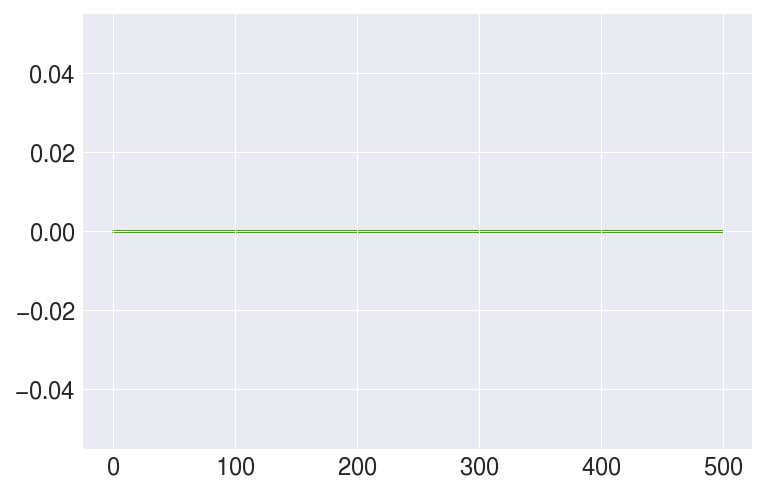

In [36]:
ndim = 3
nsample, nchain = 500, 5

#def target_log_prob(x):
#  return -2. * tf.reduce_sum((x - np.arange(ndim)) ** 2, axis=-1)

def target_log_prob(x):
    mean, var= tf.nn.moments(x, axes = [0, 1], keepdims = True)
    return -tf.reduce_sum(((2*np.pi*var)**(-0.5))*np.exp((-(x - mean)**2)/(2*var)))

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    num_leapfrog_steps=3,
    step_size=.25)

samples, is_accepted = tfp.mcmc.sample_chain(
    kernel=hmc_kernel,
    num_results=nsample,
    num_burnin_steps=50,
    trace_fn=lambda _, pkr: pkr.is_accepted,
    current_state=tf.zeros([nchain, ndim]))

for i in range(ndim):
  plt.plot(samples[..., i], alpha=.25, color=f'C{i}');

In [37]:
sampler = bilby.sampler.Emcee(likelihood, prior)

16:36 bilby INFO    : Search parameters:
16:36 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$M$', unit='$M_{\\odot}$', boundary=None)
16:36 bilby INFO    :   mass_ratio = 0.977647
16:36 bilby INFO    :   a_1 = 0.0
16:36 bilby INFO    :   a_2 = 0.0
16:36 bilby INFO    :   tilt_1 = 0.0
16:36 bilby INFO    :   tilt_2 = 0.0
16:36 bilby INFO    :   phi_12 = 0.0
16:36 bilby INFO    :   phi_jl = 0.0
16:36 bilby INFO    :   dec = -1.2232
16:36 bilby INFO    :   ra = 2.19432
16:36 bilby INFO    :   theta_jn = 1.89694
16:36 bilby INFO    :   psi = 0.532268
16:36 bilby INFO    :   luminosity_distance = 412.066
16:36 bilby INFO    :   phase = 5.30408
16:36 bilby INFO    :   geocent_time = 1126259462.4146729
16:36 bilby INFO    : Single likelihood evaluation took 1.963e-03 s
16:36 bilby INFO    : Using sampler Emcee with kwargs {'nwalkers': 500, 'a': 2, 'args': [], 'kwargs': {}, 'postargs': None, 'pool': None, 'live_dangerously': False, 'runtime

In [38]:
sampler.search_parameter_keys, sampler.use_ratio

(['chirp_mass'], False)

In [39]:
likelihood.parameters

{'mass_ratio': 0.977647,
 'a_1': 0.0,
 'a_2': 0.0,
 'tilt_1': 0.0,
 'tilt_2': 0.0,
 'phi_12': 0.0,
 'phi_jl': 0.0,
 'dec': -1.2232,
 'ra': 2.19432,
 'theta_jn': 1.89694,
 'psi': 0.532268,
 'luminosity_distance': 412.066,
 'phase': 5.30408,
 'geocent_time': 1126259462.4146729,
 'chirp_mass': 33.72121886546339}

In [40]:
test_value = 30.

likelihood.parameters.update({'chirp_mass':test_value})
assert likelihood.log_likelihood() == sampler.log_likelihood([test_value])

In [41]:
likelihood.log_likelihood()

-153552775.6428238

In [42]:
chirp_mass_prior = tfd.Uniform(25., 35.)
model_logprob = lambda x: target_log_prob(x) + chirp_mass_prior.log_prob(x)
init_state = chirp_mass_prior.sample()

In [44]:
rwmcmc_kernel = tfp.mcmc.RandomWalkMetropolis(
    model_logprob,
)

In [45]:
%%time
samples = tfp.mcmc.sample_chain(
    num_results=500,
    num_burnin_steps=100,
    current_state=init_state,
    kernel=rwmcmc_kernel,
    trace_fn=None)

2022-05-31 16:36:37.744150: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at reduction_ops_common.h:147 : INVALID_ARGUMENT: Invalid reduction dimension (0 for input with 0 dimension(s)


InvalidArgumentError: Invalid reduction dimension (0 for input with 0 dimension(s) [Op:Mean]

In [ ]:
az.plot_kde(samples, quantiles=[0.025, 0.5, 0.925], rug=True);